In [ ]:
import pandas as pd
import json
from glob import glob
import os.path as osp
import datetime
import wordcloud
from io import StringIO
import stop_words
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import re

In [ ]:
pd.set_option('display.max_colwidth', 255)

In [21]:
subjects = []
for media in ['France 3', 'France 2', 'TF1']:
    for year in ['2022']:
        for month in ['7', '8']:
            month_path = f'../data-news-json/media={media}/year={year}/month={month}'
            day_files = glob(f'{month_path}/day=*/*.json')
            for day_file in day_files:
                for line in open(day_file):
                    subject = json.loads(line)
                    subject['media'] = media.lower().replace(' ', '')
                    subjects.append(subject)

In [22]:
data = pd.DataFrame(subjects)

In [234]:
focus_media = "tf1"

In [235]:
today = datetime.date.today()
weekday = today.weekday()
start_delta = datetime.timedelta(days=weekday, weeks=1)

In [253]:
last_week_start = today - start_delta #- datetime.timedelta(days=7)

In [254]:
last_week_end = last_week_start + datetime.timedelta(days=7)

In [255]:
last_week_start, last_week_end

(datetime.date(2022, 7, 25), datetime.date(2022, 8, 1))

In [256]:
last_week = data[(data.media == focus_media)
                 & (data["date"] >= last_week_start.strftime("%Y-%m-%d")) 
                 & (data["date"] < last_week_end.strftime("%Y-%m-%d")) ].copy()

In [257]:
import re
if focus_media == 'tf1':
    topic_pattern = re.compile("https://www.tf1info.fr/(\S+)/(\S+).html")
    last_week['topic'] = [topic_pattern.match(u).group(1) for u in last_week.url]
    
if focus_media == 'france2':
    topic_pattern = re.compile("https://www.francetvinfo.fr/(\S+)/(\S+).html")
    last_week['topic'] = [topic_pattern.match(u).group(1).split('/')[0] for u in last_week.url]

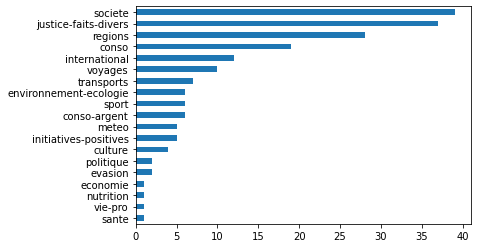

In [258]:
last_week['topic'].value_counts().plot(kind='barh').invert_yaxis()

In [259]:
last_week.columns

Index(['title', 'description', 'date', 'order', 'presenter', 'authors',
       'editor', 'editorDeputy', 'url', 'urlTvNews',
       'containsWordGlobalWarming', 'media', 'topic'],
      dtype='object')

In [260]:
last_week['formatted_date'] = [(d - datetime.timedelta(hours=20)  +datetime.timedelta(minutes=1)).strftime('%d %B, %A') for d in pd.to_datetime(last_week.date)]

In [261]:
if focus_media == 'france2':
    last_week_20h = last_week[['20h' in x for x in last_week.urlTvNews]].copy()
if focus_media == 'tf1':
    last_week_20h = last_week[[('20h' in x) or ('we' in x and d[11:13] >= "20") for x,d in zip(last_week.urlTvNews, last_week.date)]].copy()

In [262]:
if focus_media == 'tf1':
    last_week_20h['id'] = [x.split('-')[-1][:-5] for x in last_week_20h.url]
    last_week_20h['order'] = last_week_20h['date']
    order_by_id = last_week_20h.groupby('formatted_date').apply(lambda x: x.set_index('id').order.rank(method='first')).reset_index().set_index('id').order    
    last_week_20h['order'] = [order_by_id[x] for x in last_week_20h.id]

In [263]:
if False:
    last_week_20h = last_week[['we' in x for x in last_week.urlTvNews]].copy()
    last_week_20h['id'] = [x.split('-')[-1][:-5] for x in last_week_20h.url]
    last_week_20h['order'] = last_week_20h['id']
    order_by_id = last_week_20h.groupby('formatted_date').apply(lambda x: x.set_index('id').order.rank(method='first')).reset_index().set_index('id').order    
    last_week_20h['order'] = [order_by_id[x] for x in last_week_20h.id]

In [264]:
conducteur = last_week_20h.pivot(index='order', columns='formatted_date', values='title')

In [265]:
last_week_20h.formatted_date.value_counts()

26 July, Tuesday      15
27 July, Wednesday    15
25 July, Monday       13
30 July, Saturday     13
31 July, Sunday       13
28 July, Thursday     11
29 July, Friday       11
Name: formatted_date, dtype: int64

In [266]:
conducteur

formatted_date,"25 July, Monday","26 July, Tuesday","27 July, Wednesday","28 July, Thursday","29 July, Friday","30 July, Saturday","31 July, Sunday"
order,,,,,,,
1.0,"Après les incendies, le retour des touristes",Incendies dans l'Hérault : le point sur la situation,France-Allemagne : tous derrière les Bleues !,Incendies dans l'Hérault : les aveux d'un pompier volontaire,Pompier pyromane : un village sidéré,Thalys : chaos sur les rails et dans les gares,Feu dans le Gard : le point sur la situation à Gallargues-le-Montueux
2.0,Forêt : comment éviter les mégafeux,Prix des carburants : jusqu'où ira la baisse ?,"Ardèche : 8 départs de feux, près de 1000 hectares brûlés",Tourisme : le mois de juillet fait le plein !,Pyromanes : qui sont-ils ?,Incendie : des TGV à très petite vitesse,Bouches-du-Rhône : violent incendie en cours
3.0,"Remise carburant, prime inflation : combien allez-vous économiser ?",Des vendanges de plus en plus précoces dans l'Aude,Incendies en Ardèche : le point sur la situation,Été : comment un village s'adapte à l'afflux de touristes,Pyromanes : qui sont-ils ?,Journée noire : les automobilistes voient rouge,Var : une lutte éclair contre un feu naissant
4.0,Guêpes et frelons : pourquoi sont-ils si nombreux cet été ?,Bénin : la France restitue des œuvres d'art,Incendie dans le Verdon : 300 vacanciers évacués d'un camping,Vacances insolites : un âne pour compagnon de voyage,Pyromanes : une forêt sous haute surveillance,Chassé-croisé : la route des vacances sous haute surveillance,Californie : un nouvel incendie géant incontrôlable
5.0,"Lions, gorilles, hippopotames… Les animaux prennent la pose !",Vacances : le rêve américain,Incendies dans l'Hérault : des habitants soulagés,Thaïlande : la renaissance d'une plage de rêve,Gares : 400 000 voyageurs et autant de valises !,Départs en vacances : veillée d'armes chez les pompiers,Canicule : il va falloir s'y habituer
6.0,JO de Paris 2024 : des millions de billets à moins de 50 euros,VIDÉO - Bagages oubliés : découvrez la caverne d'Ali Baba de la SNCF,"Après les incendies, la dune du Pilat rouvre",Gironde : la forêt calcinée vue du ciel en ULM,Grands départs : le clignotant n’est pas une option…,Reprise du feu : inquiétude en Gironde,Sécheresse : le niveau de la Loire au plus bas
7.0,Gironde : un garage géant improvisé par les pompiers pour leur matériel détruit,Hérault : au cœur de l'incendie avec les pompiers,Sécheresse : le trafic fluvial perturbé,"Napoléon, Colbert... les statues controversées ont-elles été déboulonnées ?",Supermarchés : des promos à gogo,États-Unis : inondations dévastatrices dans le Kentucky,Le panier de vacances : la valse des prix d'une région à l'autre
8.0,Californie : le parc Yosemite sous la menace du mégafeu,"La mer en surchauffe : comment fonctionne une ""canicule marine"" ?",Assemblée nationale : cacophonie dans l'hémicycle,Faux terminaux de paiement dans les restaurants : comment procèdent les escrocs ?,Pizzas : quand l’affaire Buitoni plombe les ventes,Vacances au camping : les uns chassent les autres !,Vacances : ils ne supportent plus les touristes
9.0,"""C’est trop !"" : les vacanciers surpris par la température de la Méditerranée","Hérault : le feu, qui a détruit près de 1000 hectares, ne progresse plus","Club de plage, les enfants adorent, les parents aussi !",Pertes record d'EDF : qui va payer la facture ?,Argentine : chasse au trésor dans une décharge,"Aéroport : voyage dans les ""zones interdites""","Les aventures de Guillaume, épisode 3 : des vacances électriques !"


In [273]:
query  = "Climatisation : notre meilleur ennemie ?"
data[data.title.apply(lambda x : query in x)][['date', 'media', 'title', 'url']]

,date,media,title,url
2195,2022-07-30T20:29:00.000Z,tf1,Climatisation : notre meilleur ennemie ?,https://www.tf1info.fr/conso/video-climatisation-notre-meilleur-ennemie-2228027.html


In [274]:
print(data[data.title.apply(lambda x : query in x)]['description'].iloc[0])

Dans le pays, un foyer sur quatre est équipé d'une climatisation. Avec les fortes chaleurs, la tendance ne cesse de s'accroître. Si la climatisation est agréable, elle a aussi de sérieux inconvénients.  Elles nous sauvent quand le soleil tape fort ou quand les températures passent au rouge. Dans nos appartements, en magasin, dans nos voitures, la climatisation devient notre meilleur ami chaque été. Marseille est la ville où la climatisation est reine. Ici, comme dans tout le sud-est du pays, 47 % des ménages sont équipés d'un climatiseur, c'est deux fois plus que la moyenne nationale. Est-ce raisonnable ? Pour Yoann Chetrit, commerçant, la hausse des températures est une aubaine. Il vend des climatiseurs. Pour un climatiseur mobile, il faut compter 600 euros, et un climatiseur sans moteur extérieur coûte 3 000 euros. Et pour des modèles classiques avec moteur extérieur, il faut compter entre 1 500 et 4 500 euros. Cette année 2022, il va battre tous ses records de vente. Contrairement à